# Sequence Classification

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import InputLayer, LSTM, Bidirectional, Dense, Softmax, TimeDistributed
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style("whitegrid")

In [2]:
# To avoid:
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized.
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load Training Data

In [3]:
dataset = tf.data.Dataset.list_files("../data/robotdata/*.csv", shuffle=False)

files = []
for file in dataset:
    files.append(file.numpy().decode())

In [4]:
arrays = []
labels = []
for file in files:
    df = pd.read_csv(file)
    array = df[["front", "left"]].to_numpy()
    label = df.direction.to_numpy()
    arrays.append(array)
    labels.append(label)

arrays = [array[:1138, :] for array in arrays]
labels = [label[:1138] for label in labels]
unique_labels = np.unique(labels[0])
le = LabelEncoder()
le.fit(unique_labels)

labels = [le.transform(label) for label in labels]
labels = [tf.one_hot(label, 4) for label in labels]

Separate training, validation, and testing observations.

In [5]:
def create_dataset(arrays, labels):
    dataset = tf.data.Dataset.from_generator(lambda: iter(zip(arrays, labels)), output_types=(tf.float16, tf.uint8))
    return dataset

train_dataset = create_dataset(arrays[:3], labels[:3]).batch(1)
test_dataset = create_dataset(arrays[-1:], labels[-1:]).batch(1)
validation_dataset = test_dataset

## Define Network Architecture

In [6]:
model = Sequential([InputLayer(input_shape=(1138, 2)),
                    Bidirectional(LSTM(100, return_sequences=True)), 
                    TimeDistributed(Dense(units=4)), 
                    Softmax()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1138, 200)        82400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1138, 4)          804       
 ibuted)                                                         
                                                                 
 softmax (Softmax)           (None, 1138, 4)           0         
                                                                 
Total params: 83,204
Trainable params: 83,204
Non-trainable params: 0
_________________________________________________________________


## Specify Training Options

In [7]:
optimizer = Adam(learning_rate=0.01)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [8]:
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset)

Epoch 1/50


3/3 [==============================] - 9s 2s/step - loss: 1.3049 - categorical_accuracy: 0.3831 - val_loss: 1.1487 - val_categorical_accuracy: 0.6292
Epoch 2/50
3/3 [==============================] - 1s 512ms/step - loss: 1.1287 - categorical_accuracy: 0.5703 - val_loss: 1.0441 - val_categorical_accuracy: 0.6705
Epoch 3/50
3/3 [==============================] - 1s 503ms/step - loss: 1.0306 - categorical_accuracy: 0.6095 - val_loss: 0.9406 - val_categorical_accuracy: 0.6757
Epoch 4/50
3/3 [==============================] - 2s 536ms/step - loss: 0.9794 - categorical_accuracy: 0.5706 - val_loss: 0.9027 - val_categorical_accuracy: 0.5501
Epoch 5/50
3/3 [==============================] - 2s 522ms/step - loss: 0.8789 - categorical_accuracy: 0.6321 - val_loss: 1.2490 - val_categorical_accuracy: 0.6169
Epoch 6/50
3/3 [==============================] - 2s 534ms/step - loss: 1.0587 - categorical_accuracy: 0.6233 - val_loss: 0.8273 - val_categorical_accuracy: 0.8005
Epoch 7/50
3/3 [==============

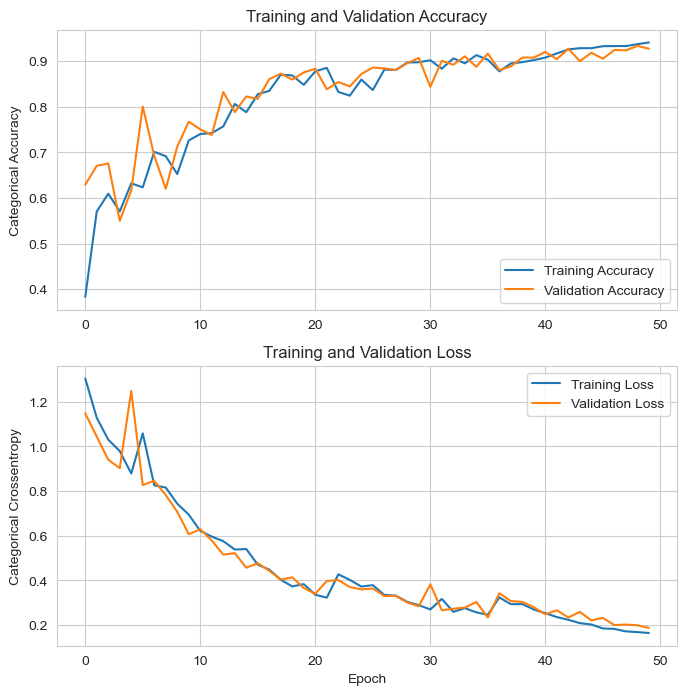

In [9]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Categorical Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.show()

## Evaluate the Model

In [10]:
for array, label in test_dataset:
    y_true = tf.argmax(label, axis=-1).numpy().flatten()

predictions = model.predict(test_dataset, verbose=False)
y_pred = tf.argmax(predictions, axis=-1).numpy().flatten()

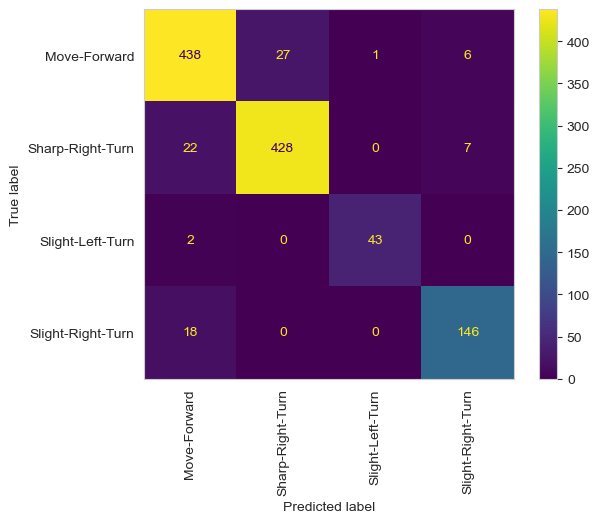

In [11]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(xticks_rotation="vertical")
plt.grid(False)
plt.show()

In [12]:
for array, label in test_dataset:
    signals = array[0].numpy()

fs = 9
front = signals[:, 0]
left = signals[:, 1]
time = np.linspace(0, len(front)/fs, len(front))

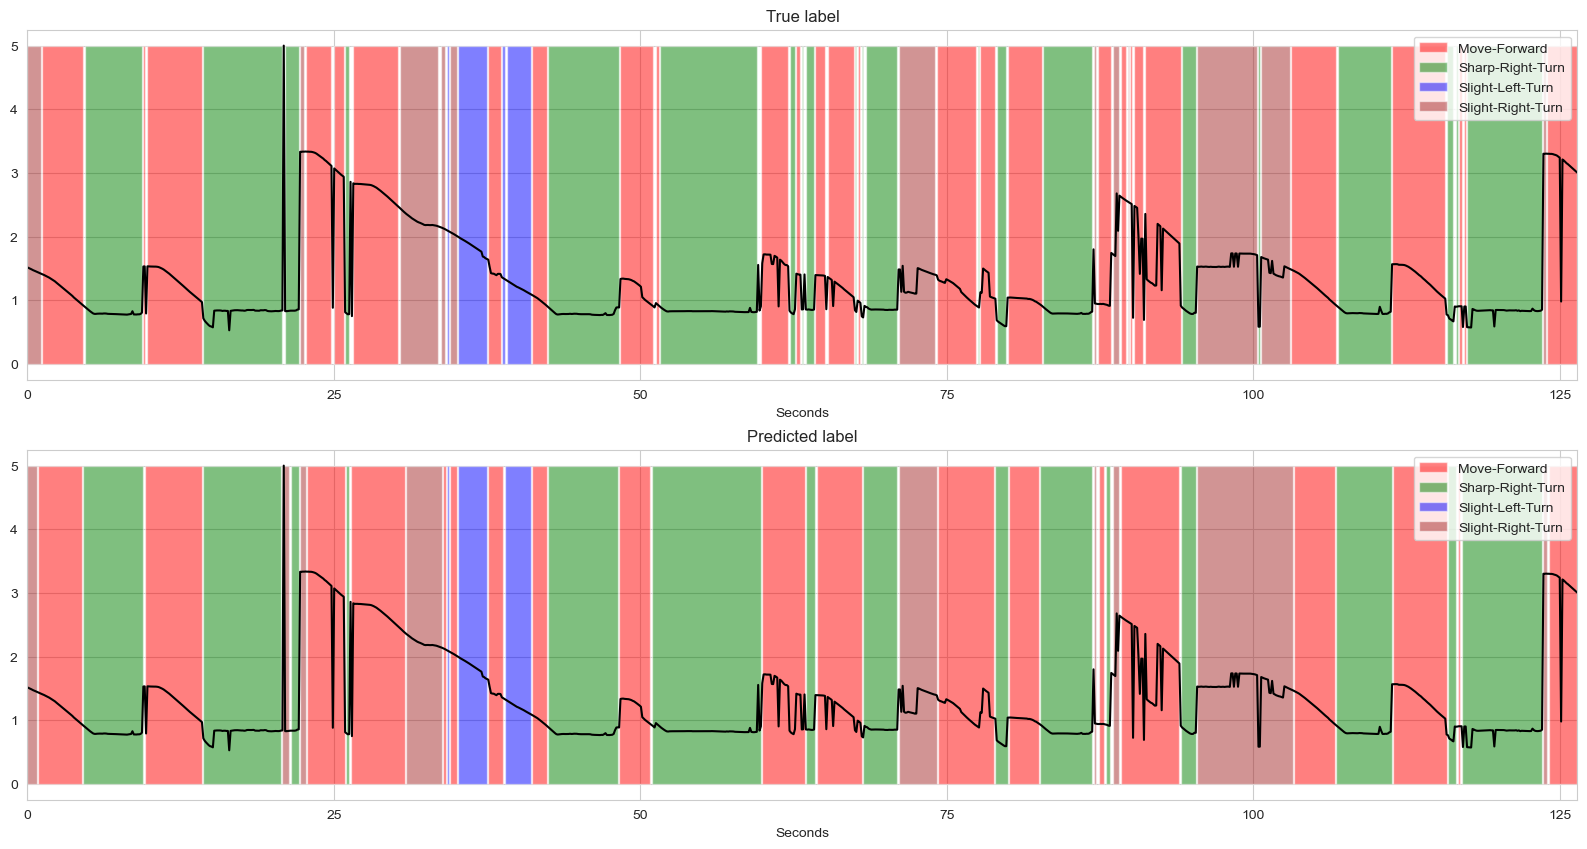

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
for ax, y, title in zip(axs.flatten(), [y_true, y_pred], ["True label", "Predicted label"]):
    for label, color in zip([0, 1, 2, 3], ["red", "green", "blue", "brown"]):
        ax.fill_between(time, front.max(), where=y==label, facecolor=color, alpha=0.5)
    ax.set_xticks(range(0, 150, 25))
    ax.legend(unique_labels)
    ax.plot(time, front, color='k')
    ax.set_xlim(0, time.max())
    ax.set_xlabel("Seconds")
    ax.set_title(title)

plt.show()